## Lesson 16 - 結構化資料庫 RDBS to Neo4j





### Table of Contents
- [About CareerVillage.org](#career_village)
- [Dataset introduction](#data_set)
- [Importing all the CSVs](#import_csv)
- [RDBS schema](#RDBS_schema)
- [Import the NODES, nodes' labels, and properties](#import_nodes)
- [Import Relationships](#import_relationships)
- [Making group type, location, and industry nodes](#making_group)
- [Cypher query](#Cypher)
- [NLP based tag enrichment](#nlp)
- [Import tags into database a rerun the tests](#import_tags)

<a id="career_village"></a>
## About CareerVillage.org
CareerVillage.org是一家非營利性組織，致力於為年輕人提供職業建議。 該平台 2011 年成立於紐約，現已為25,000名志願者，提供了超過 350 萬線上學習者的職業建議。該平台使用類似於 StackOverflow 或 Quora 的問答方式，為學生提供有關任何職業的任何問題的答案。

<a id="data_set"></a>
## Dataset introduction

First download the [data](https://www.kaggle.com/c/data-science-for-good-careervillage/data) to your computer from kaggle to a separated folder on your local computer or server (I will be going with local computer because this should save us time)

CareerVillage.org 提供了匿名數據，每個檔案都來自其資料庫中的一個資料表。

| File     | Description                                                                         |
|:-----------:|:--------------------------------------------------------------------------------:|
| answers.csv   | 答案能由註冊為專業人員發佈，但也有可能是一個回覆答案的作者                          |
| comments.csv  | 答案或問題的留言                                                                |
| emails.csv    | 收件人Email, frequency_level 是指郵件樣板，包含回答問題立即發送的Email            |
| group_memberships.csv   | 使用者可以加入任何群組，此為群組成員名單                                |
| groups.csv   | 每個群組都有專屬「類別」，群組名稱多與討論主題有關                                   |
| matchs.csv   | 一行電子郵件包含一個問題Id。一個電子郵件包含10個問題，則電子郵件Id將在此處顯示10列  |
| professionals.csv | 志願成為「專業人士」的資料，他們自願花時間在網站上回答問題                        |
| questions.csv   | 問題由學生發佈，與學生未來的職涯相關                                            |
| school_memberships.csv   | 與 group_memberships相同，此為以學校學生                              |
| students.csv   | 學生是此網站組成最重要的成員，年齡介於14至24歲之間，位於全世界各地                 |
| tag_questions.csv | 每個問題都可以加註 hashtag 標籤，通常伴隨著問題提及的分類                      |
| tag_users.csv   | 同上，這些hashtag對應的User                                                   |
| tags.csv        | 每個 hashtag 標籤的名稱                                                       |
| question_scores.csv   | 每個問題的按讚數                                                        |
| answer_scores.csv   | 每個答案的按讚數                                                          |

In [1]:
# !pip install chart_studio

In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

sns.set(color_codes=True)
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

<a id="import_csv"></a>
## Importing all the CSVs

In [3]:
answers = pd.read_csv('./data/CareerVillage/answers.csv')
comments = pd.read_csv('./data/CareerVillage/comments.csv')
emails = pd.read_csv("./data/CareerVillage/emails.csv")
group_memberships = pd.read_csv('./data/CareerVillage/group_memberships.csv')
groups = pd.read_csv('./data/CareerVillage/groups.csv')
matches = pd.read_csv('./data/CareerVillage/matches.csv')
professionals = pd.read_csv("./data/CareerVillage/professionals.csv")
questions = pd.read_csv('./data/CareerVillage/questions.csv')
school_memberships = pd.read_csv('./data/CareerVillage/school_memberships.csv')
students = pd.read_csv('./data/CareerVillage/students.csv')
tag_questions = pd.read_csv("./data/CareerVillage/tag_questions.csv")
tag_users = pd.read_csv('./data/CareerVillage/tag_users.csv')
tags = pd.read_csv('./data/CareerVillage/tags.csv')

Okay that's set, now I map the relational db schema to speed up the import and the understanding of the whole space with this free [tool](https://dbdiagram.io/). using the head of all of the dataframes and the explanation given in the data [description](https://www.kaggle.com/c/data-science-for-good-careervillage/data).

In [4]:
df_list = [answers,comments,emails,group_memberships,groups,matches,professionals,questions,school_memberships,students,tag_questions,tag_users,tags]

In [5]:
# sanity check there is 13 csv file.
len(df_list)

13

In [6]:
for table in df_list:
    print(table.columns)

Index(['answers_id', 'answers_author_id', 'answers_question_id',
       'answers_date_added', 'answers_body'],
      dtype='object')
Index(['comments_id', 'comments_author_id', 'comments_parent_content_id',
       'comments_date_added', 'comments_body'],
      dtype='object')
Index(['emails_id', 'emails_recipient_id', 'emails_date_sent',
       'emails_frequency_level'],
      dtype='object')
Index(['group_memberships_group_id', 'group_memberships_user_id'], dtype='object')
Index(['groups_id', 'groups_group_type'], dtype='object')
Index(['matches_email_id', 'matches_question_id'], dtype='object')
Index(['professionals_id', 'professionals_location', 'professionals_industry',
       'professionals_headline', 'professionals_date_joined'],
      dtype='object')
Index(['questions_id', 'questions_author_id', 'questions_date_added',
       'questions_title', 'questions_body'],
      dtype='object')
Index(['school_memberships_school_id', 'school_memberships_user_id'], dtype='object')
Index(['s

Based on previously mentioned sources and the printed one this can be produced. (I used Sublime3 for faster code production)

In [7]:
answers.head(1)

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...


In [8]:
comments.head(1)

,comments_id,comments_author_id,comments_parent_content_id,comments_date_added,comments_body
0,f30250d3c2ca489db1afa9b95d481e08,9fc88a7c3323466dbb35798264c7d497,b476f9c6d9cd4c50a7bacdd90edd015a,2019-01-31 23:39:40 UTC+0000,"First, you speak to recruiters. They are train..."


In [9]:
emails.head(1) # to find out the type of the emails_frequency_level -> varchar

,emails_id,emails_recipient_id,emails_date_sent,emails_frequency_level
0,2337714,0c673e046d824ec0ad0ebe012a0673e4,2018-12-07 01:05:40 UTC+0000,email_notification_daily


In [10]:
group_memberships.head(1)

,group_memberships_group_id,group_memberships_user_id
0,eabbdf4029734c848a9da20779637d03,9a5aead62c344207b2624dba90985dc5


In [11]:
groups.head(1) # to find out the type of the groups_group_type -> varchar

,groups_id,groups_group_type
0,eabbdf4029734c848a9da20779637d03,youth program


In [12]:
matches.head(1)

,matches_email_id,matches_question_id
0,1721939,332a511f1569444485cf7a7a556a5e54


In [13]:
professionals.dropna().head(1) # to find out the type of the cols and ignore the nan's -> varchar*3

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
15,68ecc66323b8418092fdd724aaf5be94,"New York, New York",Special Events,Event Hospitality & Operations Specialist,2011-12-26 05:00:00 UTC+0000


In [14]:
questions.head(1)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...


In [15]:
school_memberships.head(1)

,school_memberships_school_id,school_memberships_user_id
0,197406,23dce13ca6164a73aec7a3cd56a4884d


In [16]:
students.dropna().head(1)

,students_id,students_location,students_date_joined
59,9658267bc2564a85bad1e802de5fb597,"Wayne, Pennsylvania",2012-01-01 05:00:00 UTC+0000


In [17]:
tag_questions.head(1)

,tag_questions_tag_id,tag_questions_question_id
0,28930,cb43ebee01364c68ac61d347a393ae39


In [18]:
tag_users.head(1)

,tag_users_tag_id,tag_users_user_id
0,593,c72ab38e073246e88da7e9a4ec7a4472


In [19]:
tags.head(1)

,tags_tag_id,tags_tag_name
0,27490,college


In [20]:
matches.head(1)

,matches_email_id,matches_question_id
0,1721939,332a511f1569444485cf7a7a556a5e54


<a id="RDBS_schema"></a>
## RDBS schema
So we have [this](https://dbdiagram.io/d/5ff3c48580d742080a35083c) the full map of the db schema and the relationships separately. This is important we use the relationships as first class citizen of a graph database, so we can look for patterns and travelsals and not just for tags.

<img src="images/rdbs_table_schema.png">
https://dbdiagram.io/d/5ff3c48580d742080a35083c

Before we begin the import based on the Northwind example into Neo4j I'am going to collect the nodes, properties relations ships and labels. (Disclaimer: I will not going to handle the changers between professional and student, however easy it is to give two labels to a node and extra properties, because it it not needed for recommendation) Note: it is not necessary to store the ID-s the database can generate it automatically, however it is useful for the full picture and for the matching in the beginning.

**Nodes** (with labels and properties):
- Student
    - students_id char PK
    - students_location varchar
    - students_date_joined date
- Question
    - questions_id char PK
    - questions_author_id char
    - questions_date_added date
    - questions_title varchar
    - questions_body text
- Professional
    - professionals_id char PK
    - professionals_location varchar
    - professionals_industry varchar
    - professionals_headline varchar
    - professionals_date_joined date
- Answer
    - answers_id char PK
    - answers_author_id char
    - answers_question_id char
    - answers_date_added date
    - answers_body text
- Comment
    - comments_id char PK
    - comments_author_id char
    - comments_parent_content_id char
    - comments_date_added date
    - comments_body text
- Email
    - emails_id int PK
    - emails_recipient_id char
    - emails_date_sent date
    - emails_frequency_level varchar
- Group
    - groups_id char PK
    - groups_group_type varchar
- Tag
    - tags_tag_id int PK
    - tags_tag_name varchar
- School
    - school_memberships_school_id int

**Relationships**: (with **label** and properties) Note: One relationship could have just one label
- MEMBER_IN based on the
    - Table group_memberships tabel { group_memberships_group_id char, group_memberships_user_id char }
        - Ref: "groups"."groups_id" < "group_memberships"."group_memberships_group_id"
        - Ref: "students"."students_id" < "group_memberships"."group_memberships_user_id"
        - Ref: "professionals"."professionals_id" < "group_memberships"."group_memberships_user_id"
    - Table school_memberships { school_memberships_school_id int, school_memberships_user_id char }
        - Ref: "professionals"."professionals_id" < "school_memberships"."school_memberships_user_id"
        - Ref: "students"."students_id" < "school_memberships"."school_memberships_user_id"
- IS_IN based on the
    - Table matches { matches_email_id int, matches_question_id char }
        - Ref: "emails"."emails_id" < "matches"."matches_email_id"
        - Ref: "questions"."questions_id" < "matches"."matches_question_id"
- HAS_TAG based on the
    - Table tag_questions { tag_questions_tag_id int, tag_questions_question_id char }
        - Ref: "tags"."tags_tag_id" < "tag_questions"."tag_questions_tag_id"
        - Ref: "questions"."questions_id" < "tag_questions"."tag_questions_question_id"
    - Table tag_users { tag_users_tag_id int, tag_users_user_id char }
        - Ref: "tags"."tags_tag_id" < "tag_users"."tag_users_tag_id"
        - Ref: "professionals"."professionals_id" < "tag_users"."tag_users_user_id"
        - Ref: "students"."students_id" < "tag_users"."tag_users_user_id"
- AUTHOR_OF based on the
    - Ref: "students"."students_id" < "questions"."questions_author_id"
    - Ref: "professionals"."professionals_id" < "answers"."answers_author_id"
    - Ref: "professionals"."professionals_id" < "comments"."comments_author_id"
    - Ref: "students"."students_id" < "comments"."comments_author_id"
- IS_REPLY_TO based on the
    - Ref: "questions"."questions_id" < "answers"."answers_question_id"
    - Ref: "questions"."questions_id" < "comments"."comments_parent_content_id"
    - Ref: "answers"."answers_id" < "comments"."comments_parent_content_id"
- GOT_EMAIL based on the
    - Ref: "professionals"."professionals_id" < "emails"."emails_recipient_id"
    - Ref: "students"."students_id" < "emails"."emails_recipient_id"

The graph database space is addtive so we can easily make a new node type from professional location or from any desired and usefull property, moreover we can make new connection based on insights, or reduce the tags as labels

## Insert nodes query into the console
```
create (student:Student {students_id:"StudentJerry"}),(question:Question {questions_id:"Why?"}),(professional:Professional {professionals_id:"Mr. CEO"}),(answer:Answer {answers_id:"Keep delivering!"}),(comment:Comment {comments_id:"Thank you!"}),(email:Email {emails_id:"You got a question!"}), (group:Group {groups_id:"Awesome Group"}),(tag:Tag {tags_tag_id:"Future Saver"}),(school:School {schools_id:"Oxford"}), (student)-[:MEMBER_IN]->(group), (professional)-[:MEMBER_IN]->(group), (student)-[:MEMBER_IN]->(school),(professional)-[:MEMBER_IN]->(school),(student)-[:HAS_TAG]->(tag), (professional)-[:HAS_TAG]->(tag), (question)-[:HAS_TAG]->(tag), (student)-[:AUTHOR_OF]->(question), (student)-[:AUTHOR_OF]->(comment), (professional)-[:AUTHOR_OF]->(comment),(professional)-[:AUTHOR_OF]->(answer),(answer)-[:IS_REPLY_TO]->(question),(comment)-[:IS_REPLY_TO]->(question), (comment)-[:IS_REPLY_TO]->(answer), (professional)-[:GOT_EMAIL]->(email),(student)-[:GOT_EMAIL]->(email), (question)-[:QUESTION_IS_IN_EMAIL]->(email)
```

Then you will see the basic schema of the db, where any nodes can have any type of connections.

If you want to be more professional import the upper Cypher query from the upper cell to a Neo4j instance, then call:

call db.schema()

You have to allow [APOC, Awesome Procedures on Cypher](https://neo4j.com/developer/neo4j-apoc/) to do this.

After a few visualisation trick you can see the following schema:

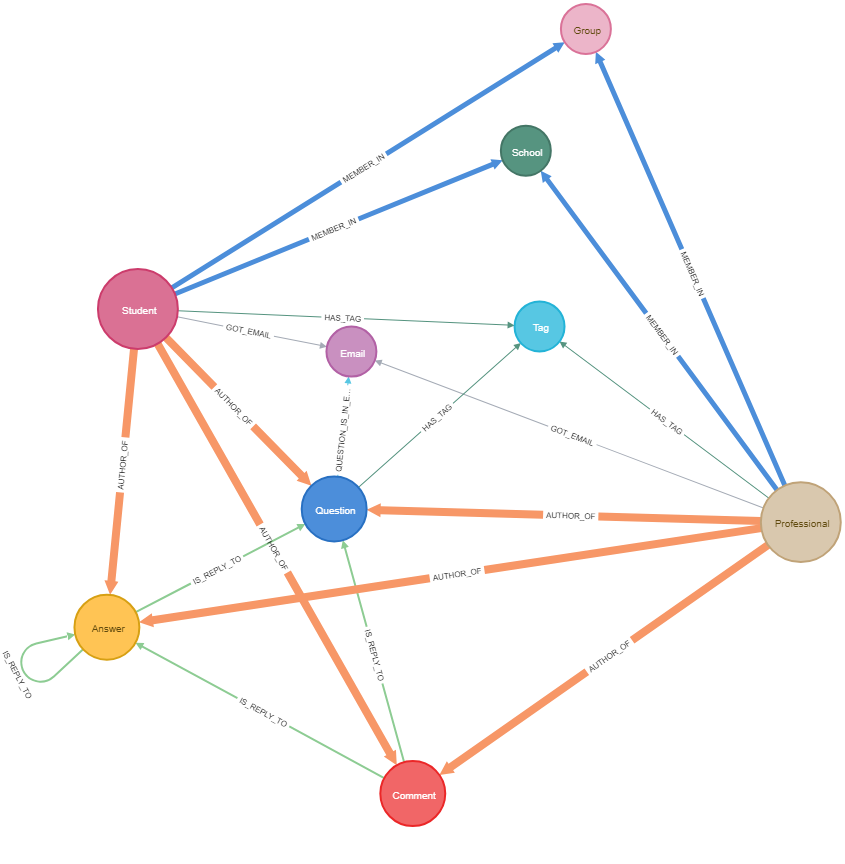

In [21]:
from IPython.display import Image
Image(filename="./images/graph_schema_kaggle.png")

Note1: COMPARE TO THIS [SQL SCHEMA](https://dbdiagram.io/d/5ff3c48580d742080a35083c)

Note2: As you can see there is a self loop in the schema but I could not figure out why, if you do please tell me.

Now we finally begin to import the CSVs to the Neo4j graph database. The previous section was just for the understanding of the process, thins are speeding up from here.

### Install APOC

<img src="images/neo4j_install_apoc.png">

For the load and for other fun things locate the neo4j.conf file on you computer, and change the line of:

```
dbms.security.procedures.whitelist=
dbms.security.procedures.allowlist=
```

to this:

```
dbms.security.procedures.allowlist=apoc.*,gds.*
```

and change the:

```
dbms.directories.import=import
```

to this:
```
dbms.directories.import=import
```

moreover change this:

```
dbms.security.procedures.unrestricted=my.extensions.example,my.procedures.*
```

to this:

```
dbms.security.procedures.unrestricted=apoc.*
```

### Copy csv to import folder

<img src="images/copy_CareerVillage_csv_to_import.png">

<a id="import_nodes"></a>
### Import the NODES, nodes' labels, and properties first: students

- students
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///students.csv" AS row CREATE (student:Student) SET student._id = row.students_id, student.location = row.students_location, student.join_date = date(LEFT(row.students_date_joined,10)), student.join_date_text = row.students_date_joined
```

- questions
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///questions.csv" AS row CREATE (question:Question) SET question._id = row.questions_id, question.author_id = row.questions_author_id, question.date_added = date(LEFT(row.questions_date_added,10)), question.date_added_text = row.questions_date_added, question.title = row.questions_title, question.body = row.questions_body
```

- professionals
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///professionals.csv" AS row CREATE (professional:Professional) SET professional._id = row.professionals_id, professional.location = row.professionals_location, professional.industry = row.professionals_industry, professional.headline = row.professionals_headline, professional.date_joined = date(LEFT(row.professionals_date_joined,10)), professional.date_joined_text = row.professionals_date_joined
```

- asnwers
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///answers.csv" AS row CREATE (answer:Answer) SET answer._id = row.answers_id, answer.author_id = row.answers_author_id, answer.question_id = row.answers_question_id, answer.date_added = date(LEFT(row.answers_date_added,10)), answer.date_added_text = row.answers_date_added, answer.body = row.answers_body
```

- comments
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///comments.csv" AS row CREATE (comment:Comment) SET comment._id = row.comments_id, comment.author_id = row.comments_author_id, comment.parent_content_id = row.comments_parent_content_id, comment.date_added = date(LEFT(row.comments_date_added,10)), comment.date_added_text = row.comments_date_added, comment.body = row.comments_body
```

- emails
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///emails.csv" AS row CREATE (email:Email) SET email._id = toInteger(row.emails_id), email.recipient_id = row.emails_recipient_id, email.date_sent = date(LEFT(row.emails_date_sent,10)), email.date_sent_text = row.emails_date_sent, email.frequency_level = row.emails_frequency_level
```

- groups
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///groups.csv" AS row CREATE (group:Group) SET group._id = row.groups_id, group.type = row.groups_group_type
```

- tags
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///tags.csv" AS row CREATE (tag:Tag) SET tag._id = toInteger(row.tags_tag_id), tag.name = row.tags_tag_name
```

- schools
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///school_memberships.csv" AS row CREATE (school:School) SET school._id = toInteger(row.school_memberships_school_id)
```

Great! You just imported all the student nodes to the database!

### Create indexes for faster maching
```
CREATE INDEX ON :School(_id)
CREATE INDEX ON :Student(_id)
CREATE INDEX ON :Question(_id)
CREATE INDEX ON :Question(author_id)
CREATE INDEX ON :Professional(_id)
CREATE INDEX ON :Answer(_id)
CREATE INDEX ON :Answer(author_id)
CREATE INDEX ON :Answer(question_id)
CREATE INDEX ON :Comment(_id)
CREATE INDEX ON :Comment(author_id)
CREATE INDEX ON :Comment(parent_content_id)
CREATE INDEX ON :Email(_id)
CREATE INDEX ON :Email(recipient_id)
CREATE INDEX ON :Group(_id)
CREATE INDEX ON :Tag(_id)
CREATE INDEX ON :School(member_id)
```

### We imported the schools from a connecting table so we are getting rid of the duplications:
```
MATCH (n:School) RETURN count(n)
MATCH (n:School) WITH n._id AS _id, COLLECT(n) AS nodelist, COUNT(n) AS count WHERE count > 1 return Count(nodelist)

MATCH (n:School) WITH n._id AS _id, COLLECT(n) AS nodelist, COUNT(n) AS count WHERE count > 1 CALL apoc.refactor.mergeNodes(nodelist) YIELD node RETURN node

MATCH (n:School) WITH n._id AS _id, COLLECT(n) AS nodelist, COUNT(*) AS count WHERE count > 1 return Count(nodelist)
MATCH (n:School) RETURN count(n)
```

<a id="import_relationships"></a>
### Import Relationships
The fun part the EDGES and edges' labels, (no properties here) (or relationships)

#### (student)-[:MEMBER_IN]->(group)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///group_memberships.csv" AS row MATCH (student:Student {_id: row.group_memberships_user_id}) MATCH (group:Group {_id: row.group_memberships_group_id}) MERGE (student)-[:MEMBER_IN]->(group)
```

#### (student)-[:MEMBER_IN]->(school)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///school_memberships.csv" AS row MATCH (student:Student {_id: row.school_memberships_user_id}) MATCH (school:School {_id: toInteger(row.school_memberships_school_id)}) MERGE (student)-[:MEMBER_IN]->(school)
```

#### (professional)-[:MEMBER_IN]->(group)*
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///group_memberships.csv" AS row MATCH (professional:Professional {_id: row.group_memberships_user_id}) MATCH (group:Group {_id: row.group_memberships_group_id}) MERGE (professional)-[:MEMBER_IN]->(group)
```

#### (professional)-[:MEMBER_IN]->(school)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///school_memberships.csv" AS row MATCH (professional:Professional {_id: row.school_memberships_user_id}) MATCH (school:School {_id: toInteger(row.school_memberships_school_id)}) MERGE (professional)-[:MEMBER_IN]->(school)
```

#### (student)-[:HAS_TAG]->(tag)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///tag_users.csv" AS row MATCH (student:Student {_id: row.tag_users_user_id}) MATCH (tag:Tag {_id: toInteger(row.tag_users_tag_id)}) MERGE (student)-[:HAS_TAG]->(tag)
```

#### (professional)-[:HAS_TAG]->(tag)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///tag_users.csv" AS row MATCH (professional:Professional {_id: row.tag_users_user_id}) MATCH (tag:Tag {_id: toInteger(row.tag_users_tag_id)}) MERGE (professional)-[:HAS_TAG]->(tag)
```

#### (question)-[:HAS_TAG]->(tag)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///tag_questions.csv" AS row MATCH (question:Question {_id: row.tag_questions_question_id}) MATCH (tag:Tag {_id: toInteger(row.tag_questions_tag_id)}) MERGE (question)-[:HAS_TAG]->(tag)
```

#### (student)-[:AUTHOR_OF]->(question)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///questions.csv" AS row MATCH (question:Question {_id: row.questions_id}) MATCH (student:Student {_id: row.questions_author_id}) MERGE (student)-[:AUTHOR_OF]->(question)
```

#### (student)-[:AUTHOR_OF]->(comment)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///comments.csv" AS row MATCH (comment:Comment {_id: row.comments_id}) MATCH (student:Student {_id: row.comments_author_id}) MERGE (student)-[:AUTHOR_OF]->(comment)
```

#### (professional)-[:AUTHOR_OF]->(comment)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///comments.csv" AS row MATCH (comment:Comment {_id: row.comments_id}) MATCH (professional:Professional {_id: row.comments_author_id}) MERGE (professional)-[:AUTHOR_OF]->(comment)
```

#### (professional)-[:AUTHOR_OF]->(answer)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///answers.csv" AS row MATCH (answer:Answer {_id: row.answers_id}) MATCH (professional:Professional {_id: row.answers_author_id}) MERGE (professional)-[:AUTHOR_OF]->(answer)
```

#### (answer)-[:IS_REPLY_TO]->(question)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///answers.csv" AS row MATCH (answer:Answer {_id: row.answers_id}) MATCH (question:Question {_id: row.answers_question_id}) MERGE (answer)-[:IS_REPLY_TO]->(question)
```

#### (comment)-[:IS_REPLY_TO]->(question)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///comments.csv" AS row MATCH (comment:Comment {_id: row.comments_id}) MATCH (question:Question {_id: row.comments_parent_content_id}) MERGE (comment)-[:IS_REPLY_TO]->(question)
```

#### (comment)-[:IS_REPLY_TO]->(answer)
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///comments.csv" AS row MATCH (comment:Comment {_id: row.comments_id}) MATCH (answer:Answer {_id: row.comments_parent_content_id}) MERGE (comment)-[:IS_REPLY_TO]->(answer)
```

#### (question)-[:QUESTION_IS_IN_EMAIL]->(email)
It's different iterative approach had taken, due to the high volume of edges and limited resources Importing the matches as nodes.
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///matches.csv" AS row CREATE (matches:Matches) SET matches.email_id = toInteger(row.matches_email_id), matches.question_id = row.matches_question_id
```

### Creating indexes
```
CREATE INDEX ON :Matches(email_id)
```
```
CREATE INDEX ON :Matches(question_id)
```

### Connect matches to question and email with and apoc method:
```
call apoc.periodic.iterate("MATCH (question:Question) with question match(matches:Matches {question_id:question._id}) return question,matches","CREATE (question)-[:GOT_EMAIL]->(matches)", {batchSize:1000}) yield batches, total return batches, total
```
```
call apoc.periodic.iterate("MATCH (email:Email) with email match(matches:Matches {email_id:email._id}) return email,matches","CREATE (email)-[:GOT_EMAIL]->(matches)", {batchSize:1000}) yield batches, total return batches, total
```

### Make the relationships between email and questions:
```
call apoc.periodic.iterate("MATCH (question:Question)-[:GOT_EMAIL]->(matches:Matches)<-[:GOT_EMAIL]-(email:Email) return email,question","CREATE (question)-[:IS_IN]->(email)", {batchSize:1000}) yield batches, total return batches, total
```

### Delete matches nodes (請先不要執行):
```
call apoc.periodic.iterate("MATCH (matches:Matches) return matches", "DETACH DELETE matches", {batchSize:1000}) yield batches, total return batches, total
```

Congratulations if you have the nodes and relationships in neo4j as it is written previously. You just uploaded a relational database into a graph database!

<img src="images/neo4j_career_village_apoc_done.png">

<a id="making_group"></a>
## Making group type, location, and industry nodes

#### make nodes from group properties
```
MATCH (n:Group) WITH COLLECT(DISTINCT n.type) AS gts UNWIND gts AS group_type MERGE (t:Group_Type {type:group_type}) WITH t,group_type MATCH (s:Group {type:group_type}) MERGE (s)-[:HAS_TYPE]->(t)
```

#### make nodes from student location
```
MATCH (n:Student) WITH COLLECT(DISTINCT n.location) as locs UNWIND locs as loc MERGE (t:Location {location:loc}) WITH t,loc MATCH (s:Student {location:loc}) MERGE (s)-[:BASED_IN]->(t)
```

#### make nodes from professional location
```
MATCH (n:Professional) WITH COLLECT(DISTINCT n.location) as locs UNWIND locs as loc MERGE (t:Location {location:loc}) WITH t,loc MATCH (p:Professional {location:loc}) MERGE (p)-[:BASED_IN]->(t)
```

#### make nodes from professional industry
```
MATCH (n:Professional) WITH COLLECT(DISTINCT n.industry) as inds UNWIND inds as ind MERGE (t:Industry {industry:ind}) WITH t,ind MATCH (p:Professional {industry:ind}) MERGE (p)-[:WORKING_IN]->(t)
```

<a id="Cypher"></a>
## Cypher query

### How many nodes whe have?
```
MATCH (n) RETURN COUNT(n) AS CountOfNodes
```
<img src="images/rds2neo4j_num_of_nodes.png">

### Relationships?

```
MATCH ()-[m]->() RETURN COUNT(m) AS CountOfRels
```
<img src="images/rds2neo4j_num_of_relationships.png">

### How many node labels we have grouped by type?
```
CALL db.labels() YIELD label CALL apoc.cypher.run("MATCH (:"+label+") RETURN count(*) as count", null) YIELD value RETURN label, value.count AS count ORDER BY count DESC
```
<img src="images/rds2neo4j_labels.png">

### How many relationships we have grouped by type?
```
CALL db.relationshipTypes() YIELD relationshipType CALL apoc.cypher.run("MATCH ()-[:"+relationshipType +"] -> () RETURN count(*) as count", null) YIELD value RETURN relationshipType, value.count AS count ORDER BY count DESC
```
<img src="images/rds2neo4j_relationships_types.png">

One questions tags are connecting other questions, professionals and student to each other: Red: Student Dust: Professional DarkBlue: Question LightBlue: Tag

<img src="images/neo4j_career_village_query_test.png">

We could go deeper, and get lost in the graph but I would like to take and iterative approach to build the recommendation engine and explore the graph along the path.

Approach One to Recommendation Engine Get similar questions (with answers) to the student's unanswered questions, because this is THE fastes way to get answers to the students because it only depends on past professional activity and do not need future one, in most cases, I call this as a first line of help.

### Check out the unanswered questions:
```
MATCH (q:Question) WHERE not exists ((q)-[:IS_REPLY_TO]-(:Answer)) WITH q MATCH (q)-[:HAS_TAG]-(t:Tag) return q._id AS question_id, count(t) as tag_c order by tag_c desc
```

The dataset has 807 unanswered questions, and the db had given this result in 154 ms

<img src="images/rds2neo4j_find_unwind_noides.png">

Check out these questions, the "5194c9cac7134c868beb02f83c1a5bbf" with 14 tags and the "dab7b240dc394d30a54dd0c5862d5fe" one with 3 tags.
```
MATCH (q:Question {_id:"dab7b240dc394d30a54dd0c5862d5fe3"})-[r]-(k) return q,r,k
```

As you can see an unanswered question on has 3 types of nodes in the neighbourhood, the tags, the email and the author, our best path is on the tags.
```
MATCH (q:Question {_id:"5194c9cac7134c868beb02f83c1a5bbf"})-[r:HAS_TAG]-(t:Tag) return q,r,t limit 300
```
<img src="images/rds2neo4j_graph_query_question.png">


Get similar answers based on Jaccard index for the question with 3 tags:
```
MATCH (q_or:Question {
  _id:"dab7b240dc394d30a54dd0c5862d5fe3"
})-[:HAS_TAG]-(t:Tag)-[:HAS_TAG]-(q_ot:Question)-[IS_REPLY_TO]-(a:Answer)
WITH q_or, q_ot, COUNT(t) AS intersection, COLLECT(t.name) AS i
MATCH (q_or)-[:HAS_TAG]-(o_or:Tag)
WITH q_or, q_ot, intersection, i, COLLECT(o_or.name) AS s1
MATCH (q_ot)-[:HAS_TAG]-(o_ot:Tag)
WITH q_or, q_ot, intersection, i, s1, COLLECT(o_ot.name) AS s2
WITH q_or, q_ot, intersection, s1, s2
WITH q_or, q_ot, intersection, s1+[x IN s2 WHERE NOT x IN s1] AS UNION , s1, s2
RETURN q_or.title, q_ot.title, s1, s2, ((1.0*intersection)/SIZE(UNION)) AS jaccard ORDER BY jaccard DESC
LIMIT 20
```

- Original question title: "Are there any resume items which would make my college application really stand out?"
- Most similar question: "How do you make your university application stand out?"
- Second: "Can someone proofread my college transfer essay?"
- Third: "What should I look for if I am considering transferring colleges?"
- Fourth: "How do you build your resume in college?"
- Fifth: "How did you decide which college to attend?"

<img src="images/rds2neo4j_jaccard.png">

So it is quite powerful, considering it is only a query in a db with 2M nodes and 6M relationships and had given these results in 211 ms so it has real time applications

### Get similar answers based on Jaccard index for the question with 14 tags:
```
MATCH (q_or:Question {
  _id:"5194c9cac7134c868beb02f83c1a5bbf"
})-[:HAS_TAG]-(t:Tag)-[:HAS_TAG]-(q_ot:Question)-[IS_REPLY_TO]-(a:Answer)
WITH q_or, q_ot, COUNT(t) AS intersection, COLLECT(t.name) AS i
MATCH (q_or)-[:HAS_TAG]-(o_or:Tag)
WITH q_or, q_ot, intersection, i, COLLECT(o_or.name) AS s1
MATCH (q_ot)-[:HAS_TAG]-(o_ot:Tag)
WITH q_or, q_ot, intersection, i, s1, COLLECT(o_ot.name) AS s2
WITH q_or, q_ot, intersection, s1, s2
WITH q_or, q_ot, intersection, s1+[x IN s2 WHERE NOT x IN s1] AS UNION , s1, s2
RETURN q_or.title, q_ot.title, s1, s2, ((1.0*intersection)/SIZE(UNION)) AS jaccard ORDER BY jaccard DESC
LIMIT 20
```
- Original question title: "What are the best free resources for MCAT prep?"
- - Most similar question: "How have you reacted to the people who have told you that you don't have what it takes to become a doctor/surgeon?"
- Second: "What helps you study for a test?"
- Third: "How do I decide between career paths?"
- Fourth: "What is the most rewarding part about being a doctor?"
- Fifth: "What would you tell a high school/college student who has goals of attending Medical School but isn't sure what to specialize in?"

It was a bit slower 1139ms and you can build a recommendation function for a push of a button.

### Simpler solution and example with the 3 tags:
```
MATCH (q_o:Question {_id:"dab7b240dc394d30a54dd0c5862d5fe3"})-[:HAS_TAG]-(t:Tag)-[:HAS_TAG]-(q_s:Question)-[IS_REPLY_TO]-(a:Answer)-[:IS_REPLY_TO]-(c:Comment) RETURN q_o.title AS Question_WithOut_Answer, q_s.title AS Similar_Question, a.body AS Answers, count(distinct t) as tag_count, count(distinct c) as comment_count ORDER BY tag_count desc,comment_count desc limit 5
```
<img src="images/rds2neo4j_simpler_with_3_tags.png">

Approach Two to Recommendation Engine recommend a professional who had answered questions with similar tags

Question with 3 tags:
```
MATCH (q_o:Question {_id:"dab7b240dc394d30a54dd0c5862d5fe3"})-[:HAS_TAG]-(t:Tag)-[:HAS_TAG]-(q_s1:Question)-[:IS_REPLY_TO]-(a:Answer)-[:AUTHOR_OF]-(p:Professional)-[:AUTHOR_OF]-(a_o:Answer)-[:IS_REPLY_TO]-(q_s2:Question)-[:HAS_TAG]-(:Tag)-[:HAS_TAG]-(q_o) RETURN q_o.title AS Question_WithOut_Answer, p._id AS Professional, count(distinct t) as tag_count, count(distinct a_o) as p_a_count ORDER BY tag_count desc, p_a_count desc limit 5
```
<img src="images/rds2neo4j_question_with_3_tags.png">
As you can see the best improvement opportunity is to upgrade the tagging system.

<a id="nlp"></a>
## NLP based tag enrichment

In [22]:
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']

In [23]:
'''
python -m spacy download en_core_web_sm
python -m spacy download zh_core_web_sm
'''
    
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')

# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

    """    
    def token_filter(token):
        """ Keep tokens who are alphapetic, in the pos (part-of-speech) list and not in stop list

        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(set(filtered_tokens))
    return processed_tokens

# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

In [24]:
questions['nlp_tokens'].head()

0    {question, college, professor, math, career, u...
1    {priyanka, officer, question, college, std, wa...
2    {increase, care, working, idea, huge, willl, f...
3    {network, hear, know, networking, hard, busine...
4    {highschoolsenior, find, college, state, first...
Name: nlp_tokens, dtype: object

In [25]:
# Removing token which are more than x% of the questions
all_q_tokens = list(questions['nlp_tokens'])

In [26]:
type(all_q_tokens)

list

In [27]:
all_unique_q_tokens = set([token for token_list in all_q_tokens for token in token_list])
flat_q_tokens = [token for token_list in all_q_tokens for token in token_list]

In [28]:
len(all_q_tokens)

23931

In [29]:
all_q_tokens[:1]

[{'career',
  'college',
  'lecture',
  'math',
  'professor',
  'question',
  'teacher',
  'useful'}]

In [30]:
len(all_unique_q_tokens)

14223

In [31]:
list(all_unique_q_tokens)[:5]

['swedish', 'creativewriting', 'mackenzie', 'benefit', 'associated']

In [32]:
len(flat_q_tokens)

398356

In [33]:
flat_q_tokens[:5]

['question', 'college', 'professor', 'math', 'career']

In [34]:
from collections import Counter,OrderedDict

tokens_sum = Counter(flat_q_tokens)
sorted_ord_tokens = sorted(tokens_sum.items(), key=lambda kv: kv[1],reverse=True)

In [35]:
sorted_ord_tokens[:5]

[('college', 8969),
 ('want', 8637),
 ('know', 6346),
 ('career', 6158),
 ('school', 6072)]

In [36]:
q_exp = questions[['questions_id','nlp_tokens']]

def replace_dict(dic):
    return str(dic).replace('{','').replace('}','').replace("'",'').replace(' ','')
    #return ','.join(str(dic).replace('{','').replace('}','').split(','))
q_exp['nlp_tokens'] = q_exp['nlp_tokens'].apply(lambda x: replace_dict(x))

In [37]:
q_exp.head()

,questions_id,nlp_tokens
0,332a511f1569444485cf7a7a556a5e54,"question,college,professor,math,career,useful,..."
1,eb80205482e4424cad8f16bc25aa2d9c,"priyanka,officer,question,college,std,want,mil..."
2,4ec31632938a40b98909416bdd0decff,"increase,care,working,idea,huge,willl,find,lea..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,"network,hear,know,networking,hard,business,are..."
4,5af8880460c141dbb02971a1a8369529,"highschoolsenior,find,college,state,firstgener..."


In [38]:
q_exp.to_csv("opt/csv/CareerVillage/q_exp_id_and_nlp_tokens.csv", index=False)

In [39]:
q_exp.head().to_csv("opt/csv/CareerVillage/q_exp_test_5.csv", index=False)

<a id="import_tags"></a>
## Import tags into database a rerun the tests

copy q_exp_id_and_nlp_tokens.csv to ./import folder

Use this code to generate mora tags based on the questions, and answer tags.
```
:auto USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "file:///q_exp_id_and_nlp_tokens.csv" AS row MATCH (q:Question {_id:row.questions_id}) WITH SPLIT (row.nlp_tokens, ",") AS tags,q,row UNWIND tags as tag CREATE (t:Token:Tag {name:tag}) CREATE (q)-[:HAS_TAG]->(t)
```

```
CREATE INDEX ON :Tag(name)
CREATE INDEX ON :Token(name)
```

```
MATCH (n:Tag) WITH n.name AS name, COLLECT(n) AS nodelist, COUNT(*) AS count WHERE count > 1 CALL apoc.refactor.mergeNodes(nodelist) YIELD node RETURN node
```

## Summary

Now we import CareerVillage CSV to the databased and use it for the "who can answer these questions" recommendation practice.

I guess that when combined with a recommendation system it would mean that any solution created for CareerVillage can potentially to be automatically updated as new professionals join, new questions are answered etc. I look forward to seeing a working prototype solution, even a very simple one, that uses this technique.